# Exercise 2: Part 3

# Import the necessary libraries and open the data set

In [215]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, ShuffleSplit, cross_val_score
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
from math import log

df = pd.read_csv('train.tsv', sep='\t')
target = df["Label"]

# Entropy Calculation Function

In [216]:
def entropy(data):
    count = data.shape[0]
    if(count==0):
        return 0
    good = len(data[data["Label"]==1])
    bad = len(data[data["Label"]==2])
    goodper = good / count
    badper = bad/count
    goodentropy =0.0
    if(good>0):
        goodentropy = -(goodper*log(goodper, 2))
    badentropy =0.0
    if(bad>0):
        badentropy = -(badper*log(badper, 2))
    entropy = goodentropy+badentropy
    return entropy

# Calculate the train set's category.

In [217]:
data_set_entropy=entropy(df)
count = len(df)

# Because those 3 numerical attributes have a big variety of values we have to convert them to categorical.

In [218]:
Attributes = list(df.columns.values)
Attributes.remove('Id')
Attributes.remove('Label')

ndf = df.copy()

NumericalAttributes = ['Attribute2', 'Attribute5',  'Attribute13']
for Attribute in NumericalAttributes:
    ndf[Attribute] = pd.qcut(df[Attribute], 5)
    


# Calculate the Information Gain for each Attribute.

In [219]:
Attributes = list(df.columns.values)
Attributes.remove('Id')
Attributes.remove('Label')

InformationGain_list=[]
for Attribute in Attributes:
    Attribute_values= list(ndf[Attribute].unique())
    attr_entropy = 0.0
    for value in Attribute_values:
        value_set= ndf[ndf[Attribute]==value]
        attr_entropy += (len(value_set)/count)*entropy(value_set)
    InformationGain_list.append((Attribute, data_set_entropy-attr_entropy))

# Sort the Information Gain List, convert the categorical to numerical.

In [220]:
InformationGain_list.sort(key=lambda tup: tup[1])

categories = ["Attribute1","Attribute3","Attribute4","Attribute6","Attribute7","Attribute9","Attribute10","Attribute10","Attribute12","Attribute14","Attribute15", "Attribute17", "Attribute19","Attribute20"]
target = df["Label"]

new_df = df.copy()
for x in categories:
    converted = pd.Categorical(df[x])
    new_df[x] = converted.codes

# Print the Array with the Attribute Removal Queue and the Information Gain for each one.

In [221]:
for n in range(len(InformationGain_list)):
    print('Exclude No: ',n,' \tAttribute: ', InformationGain_list[n][0],' \tInformation Gain: ',InformationGain_list[n][1])

Exclude No:  0  	Attribute:  Attribute18  	Information Gain:  0.0001296657019278502
Exclude No:  1  	Attribute:  Attribute11  	Information Gain:  0.00022057134927411237
Exclude No:  2  	Attribute:  Attribute19  	Information Gain:  0.0012028625910776025
Exclude No:  3  	Attribute:  Attribute16  	Information Gain:  0.002395770112591733
Exclude No:  4  	Attribute:  Attribute17  	Information Gain:  0.0029403166312881313
Exclude No:  5  	Attribute:  Attribute10  	Information Gain:  0.005674399790160045
Exclude No:  6  	Attribute:  Attribute14  	Information Gain:  0.007041506325139002
Exclude No:  7  	Attribute:  Attribute8  	Information Gain:  0.007330500076830004
Exclude No:  8  	Attribute:  Attribute20  	Information Gain:  0.007704386546436126
Exclude No:  9  	Attribute:  Attribute15  	Information Gain:  0.011618886823694607
Exclude No:  10  	Attribute:  Attribute13  	Information Gain:  0.0117447128999153
Exclude No:  11  	Attribute:  Attribute9  	Information Gain:  0.012746841156174304
E

# Loop where we remove an attribute each time, we do 10-fold cross validation and we record the accuracy. 
# We keep the max accuracy in order to use it in testSet_Predictions.

In [222]:
kf = KFold(n_splits=10)

cutted_df = df.copy()
exclude=["Id", "Label"]
xlist =[]
ylist =[]
max = 0.0
maxcount =0
for count in range(len(InformationGain_list)):
    if(count>0): 
        attr = InformationGain_list[count-1][0]
        exclude.append(attr)
    
    my_df = new_df.copy()
    
    excl =df.columns.difference(exclude)
    new_df_to_use = new_df[excl]
    
    xlist.append(len(InformationGain_list)-count)
    RANDOM_STATE = 123
    
    accuracy = 0.0

    for x,y in kf.split(new_df_to_use):
        test = new_df_to_use.loc[y,new_df_to_use.columns]
        train = new_df_to_use.loc[x, new_df_to_use.columns]
        current_target = target[x]

        classifier= RandomForestClassifier(random_state=RANDOM_STATE)
        clf = classifier.fit(train,current_target)
        yPred = clf.predict(test)
        acc = accuracy_score(target[y], yPred)
        accuracy += acc

    accuracyRF = accuracy/10
    if(max < accuracyRF):
        max = accuracyRF
        maxcount =len(InformationGain_list)-count
    ylist.append(accuracyRF)

# Show the Accuracy Plot

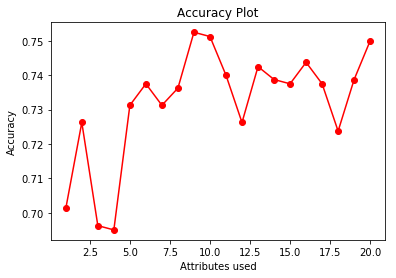

In [223]:
plt.plot(xlist, ylist, "ro-")
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Attributes used')
plt.show()

# We create the exclude list in order to get the max accuracy by removing them.

In [224]:
exclude=["Id", "Label"]
for count in range(maxcount):
    if(count>0): 
        attr = InformationGain_list[count-1][0]
        exclude.append(attr)

# Open test.tsv convert its attributes to numerical and cut the attributes we don't need.

In [225]:
dfT = pd.read_csv('test.tsv', sep='\t')
categories = ["Attribute1","Attribute3","Attribute4","Attribute6","Attribute7","Attribute9","Attribute10","Attribute12","Attribute14","Attribute15", "Attribute17", "Attribute19","Attribute20"]
new_dfT = dfT.copy()

IDs = dfT["Id"]
for x in categories:
    converted = pd.Categorical(dfT[x])
    new_dfT[x] = converted.codes


excl =df.columns.difference(exclude)
new_df_to_use = new_df[excl]
    
dfneT =dfT.columns.difference(exclude)
new_dfT = new_dfT[dfneT]

category_dict = {1:'Good', 2:'Bad'}

# Call the Random Forest Classifier, as he had the best accuracy. 
# Print the results in the testSet_Predictions.csv.

In [226]:
classifier = RandomForestClassifier(random_state=RANDOM_STATE)
classifier.fit(new_df_to_use, target)
prediction = classifier.predict(new_dfT)

id =0
with open('testSet_categories_Predictions.csv', 'w') as csvfile:
    fieldnames = ['ID', 'Label']
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames, delimiter='\t')
    writer.writeheader()
    for i in range(len(prediction)):
        writer.writerow({'ID': IDs[i], 'Label': category_dict[prediction[i]]})
        id +=1
print('Created testSet_categories_Predictions.csv')

Created testSet_categories_Predictions.csv
